In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install "monai[einops]"
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import torch

print('Python:', sys.version)     #  3.7.9
print('Numpy:', np.__version__)    # 1.20.3
print('torch', torch.__version__)

Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
Numpy: 1.21.6
torch 1.13.0


In [3]:
import tensorflow.python.platform.build_info as build
print("cuda version: ", build.build_info['cuda_version'])
print("cudnn: ", build.build_info['cudnn_version'])

cuda version:  11.2
cudnn:  8


In [4]:
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 996688436141350393
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15732572160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12374642687694589881
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [5]:
print(tf.__version__)

2.11.0


In [6]:
import os
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import monai
from monai.utils import first, set_determinism
from monai.transforms import (AsDiscrete, AsDiscreted, EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandFlipd,RandShiftIntensityd,Activations,
                              RandCropByPosNegLabeld, SaveImaged, ScaleIntensityRanged, Spacingd, Invertd, DataStatsd, Resized, RandRotate90d)
# from monai.transforms import Compose, AddChanneld, ScaleIntensityd, Resized, SpatialPad, AsDiscrete, ToTensor, LoadImaged, Activations, Rotate90d,ResizeWithPadOrCropd, EnsureChannelFirstd, SpatialPadd, EnsureTyped, ConcatItemsd, AddChanneld, AsDiscreted, ScaleIntensity, Flipd
from monai.networks.nets import UNet, VNet, AttentionUnet, BasicUNetPlusPlus, UNETR, SwinUNETR
from monai.losses import DiceCELoss, DiceLoss, DiceFocalLoss, TverskyLoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, MeanIoU
from monai.utils import set_determinism
from monai.data import DataLoader, decollate_batch, CacheDataset, Dataset
from monai.handlers.utils import from_engine
from torchvision.utils import save_image
from monai.config import print_config

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 1.3.5
einops version: 0.6.1
transformers version: 4.26.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
set_determinism(seed=777)

In [9]:
os.listdir("/kaggle/input/")

['washu-vat-scat-43']

In [10]:
data_dir= "/kaggle/input/washu-vat-scat-43/"
img_dir= os.path.join(data_dir, "images_clahe/")
mask_dir=  os.path.join(data_dir, "masks/")

image_paths = sorted(glob.glob(img_dir + "*.nii"))
mask_paths = sorted(glob.glob(mask_dir + "*.nii"))


'''--------------------split data into train and validation and test sets--------------------'''

train_temp_images, test_images, train_temp_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.2)
train_images, valid_images, train_masks, valid_masks = train_test_split(train_temp_images, train_temp_masks, test_size=0.2)

print(f'#training samples: {np.shape(train_images)[0]}, #validation samples: {np.shape(valid_images)[0]}, #test samples: {np.shape(test_images)[0]}')

#training samples: 27, #validation samples: 7, #test samples: 9


In [11]:
train_files = [{"image": image_name, "label": label_name}
               for image_name, label_name in zip(train_images, train_masks)]

val_files = [{"image": image_name, "label": label_name}
               for image_name, label_name in zip(valid_images, valid_masks)]

test_files = [{"image": image_name, "label": label_name}
               for image_name, label_name in zip(test_images, test_masks)]

In [12]:
roi_size= (96, 96, 32)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=roi_size,
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

image shape: torch.Size([256, 192, 64]), label shape: torch.Size([256, 192, 64])


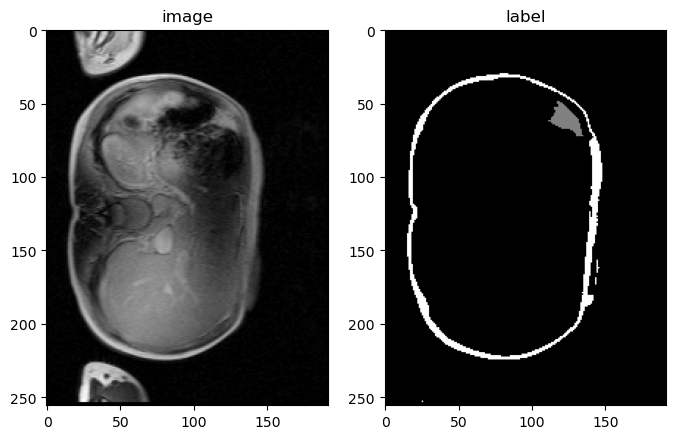

In [13]:
slice_idx=40
check_ds= Dataset(data= val_files, transform = val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data= first(check_loader)

image, label= check_data["image"][0][0], check_data["label"][0][0]
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (8, 6))
plt.subplot(121)
plt.title("image")
plt.imshow(image[:, :, slice_idx], cmap= 'gray')
plt.subplot(122)
plt.title("label")
plt.imshow(label[:, :, slice_idx], cmap= 'gray')
plt.show()

In [14]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, pin_memory=torch.cuda.is_available() )

val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

In [15]:
# import matplotlib.pyplot as plt

# # get the first batch of data
# batch = next(iter(train_loader))

# # plot the first image and the corresponding masks
# fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
# axs[0].imshow(batch["img"][0, 0], cmap="gray")
# axs[0].set_title("Image")
# for i in range(3):
#     mask = batch["label"][0, i]
#     axs[i+1].imshow(mask, cmap="gray")
#     axs[i+1].set_title(f"Class {i+1} Mask")
# plt.show()

# # Note: batch["img"][0, 0], The second [0] is indexing the first channel in the image.
# # Note: batch["img"][0][0] is equal to batch["img"][0, 0]

In [16]:
num_classes= 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VNet(spatial_dims=3,
#              in_channels=1,
#              out_channels=num_classes,
#              dropout_prob = 0.2).to(device)

model= SwinUNETR(
                        img_size=roi_size, 
                        in_channels=1,  ## 3 channels, R,G,B, 1 channels for Grayscale
                        out_channels=num_classes,
                        feature_size=24, # should be divisible by 12
                        spatial_dims=3
                    ).to(device)

# model = UNETR(
#     in_channels=1,
#     out_channels=num_classes,  # num_class
#     img_size=roi_size,
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.2,
# ).to(device)

# model = UNet(spatial_dims=3,
#                 in_channels=1,
#                 out_channels=num_classes,
#                 channels=(16, 32, 64, 128, 256, 512),
#                 strides=(2, 2, 2, 2, 2),
#                 kernel_size=3,
#                 up_kernel_size=3).to(device)


loss_function = TverskyLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [17]:
model_path = "trained_model/"
os.makedirs(model_path, exist_ok=True)
root_dir= model_path

In [18]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 250
post_label = AsDiscrete(to_onehot=num_classes)
post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
iou_metric= MeanIoU(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


Training (250 / 25000 Steps) (loss=0.30640):  30%|██▉       | 8/27 [00:18<01:30,  4.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6502952575683594 Current Avg. Dice: 0.6502952575683594


Training (500 / 25000 Steps) (loss=0.49884):  56%|█████▌    | 15/27 [00:24<00:55,  4.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7086511254310608 Current Avg. Dice: 0.7086511254310608


Training (750 / 25000 Steps) (loss=0.36857):  81%|████████▏ | 22/27 [00:28<00:22,  4.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7502683401107788 Current Avg. Dice: 0.7502683401107788


Training (1000 / 25000 Steps) (loss=0.23656):   7%|▋         | 2/27 [00:14<03:31,  8.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8016611933708191 Current Avg. Dice: 0.8016611933708191


Training (1250 / 25000 Steps) (loss=0.19787):  33%|███▎      | 9/27 [00:19<01:25,  4.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8201805949211121 Current Avg. Dice: 0.8201805949211121


Training (1500 / 25000 Steps) (loss=0.21357):  59%|█████▉    | 16/27 [00:24<00:50,  4.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8309507369995117 Current Avg. Dice: 0.8309507369995117


Training (1750 / 25000 Steps) (loss=0.13399):  85%|████████▌ | 23/27 [00:29<00:18,  4.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8409042358398438 Current Avg. Dice: 0.8409042358398438


Training (2000 / 25000 Steps) (loss=0.16292):  11%|█         | 3/27 [00:15<02:40,  6.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8413505554199219 Current Avg. Dice: 0.8413505554199219


Training (2250 / 25000 Steps) (loss=0.26889):  37%|███▋      | 10/27 [00:20<01:19,  4.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.843719482421875 Current Avg. Dice: 0.843719482421875


Training (2500 / 25000 Steps) (loss=0.23821):  63%|██████▎   | 17/27 [00:25<00:44,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.843719482421875 Current Avg. Dice: 0.8408166170120239


Training (2750 / 25000 Steps) (loss=0.33942):  89%|████████▉ | 24/27 [00:30<00:13,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.843719482421875 Current Avg. Dice: 0.843596339225769


Training (3000 / 25000 Steps) (loss=0.21480):  15%|█▍        | 4/27 [00:16<02:14,  5.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8453909754753113 Current Avg. Dice: 0.8453909754753113


Training (3250 / 25000 Steps) (loss=0.16024):  41%|████      | 11/27 [00:21<01:14,  4.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8483332395553589 Current Avg. Dice: 0.8483332395553589


Training (3500 / 25000 Steps) (loss=0.19236):  67%|██████▋   | 18/27 [00:25<00:40,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8483332395553589 Current Avg. Dice: 0.8388569951057434


Training (3750 / 25000 Steps) (loss=0.17386):  93%|█████████▎| 25/27 [00:30<00:09,  4.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8495692014694214 Current Avg. Dice: 0.8495692014694214


Training (4000 / 25000 Steps) (loss=0.12012):  19%|█▊        | 5/27 [00:16<01:57,  5.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8495692014694214 Current Avg. Dice: 0.839217483997345


Training (4250 / 25000 Steps) (loss=0.14155):  44%|████▍     | 12/27 [00:21<01:09,  4.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8520447611808777 Current Avg. Dice: 0.8520447611808777


Training (4500 / 25000 Steps) (loss=0.19106):  70%|███████   | 19/27 [00:26<00:37,  4.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8520447611808777 Current Avg. Dice: 0.8433173298835754


Training (4750 / 25000 Steps) (loss=0.08728):  96%|█████████▋| 26/27 [00:31<00:04,  4.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8520447611808777 Current Avg. Dice: 0.8482680916786194


Training (5000 / 25000 Steps) (loss=0.09512):  22%|██▏       | 6/27 [00:17<01:45,  5.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8520447611808777 Current Avg. Dice: 0.8469616770744324


Training (5250 / 25000 Steps) (loss=0.16843):  48%|████▊     | 13/27 [00:22<01:04,  4.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8553999662399292


Training (5500 / 25000 Steps) (loss=0.10322):  74%|███████▍  | 20/27 [00:27<00:31,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8549370169639587


Training (5750 / 25000 Steps) (loss=0.13098): 100%|██████████| 27/27 [00:31<00:00,  1.19s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8530402779579163


Training (6000 / 25000 Steps) (loss=0.26873):  26%|██▌       | 7/27 [00:18<01:37,  4.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8454142808914185


Training (6250 / 25000 Steps) (loss=0.09942):  52%|█████▏    | 14/27 [00:22<00:58,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8518713712692261


Training (6500 / 25000 Steps) (loss=0.10206):  78%|███████▊  | 21/27 [00:27<00:27,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8481059670448303


Training (6750 / 25000 Steps) (loss=0.12731):   4%|▎         | 1/27 [00:13<06:02, 13.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8553999662399292 Current Avg. Dice: 0.8493160605430603


Training (7000 / 25000 Steps) (loss=0.13758):  30%|██▉       | 8/27 [00:18<01:31,  4.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8557997941970825 Current Avg. Dice: 0.8557997941970825


Training (7250 / 25000 Steps) (loss=0.08447):  56%|█████▌    | 15/27 [00:23<00:54,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8557997941970825 Current Avg. Dice: 0.8517120480537415


Training (7500 / 25000 Steps) (loss=0.26705):  81%|████████▏ | 22/27 [00:28<00:22,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8557997941970825 Current Avg. Dice: 0.8555909395217896


Training (7750 / 25000 Steps) (loss=0.06910):   7%|▋         | 2/27 [00:14<03:31,  8.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8565763831138611


Training (8000 / 25000 Steps) (loss=0.10882):  33%|███▎      | 9/27 [00:19<01:24,  4.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8542324900627136


Training (8250 / 25000 Steps) (loss=0.08478):  59%|█████▉    | 16/27 [00:24<00:49,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8514524102210999


Training (8500 / 25000 Steps) (loss=0.19258):  85%|████████▌ | 23/27 [00:28<00:17,  4.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8535639643669128


Training (8750 / 25000 Steps) (loss=0.08166):  11%|█         | 3/27 [00:15<02:37,  6.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8532236814498901


Training (9000 / 25000 Steps) (loss=0.16601):  37%|███▋      | 10/27 [00:20<01:18,  4.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8494628071784973


Training (9250 / 25000 Steps) (loss=0.14990):  63%|██████▎   | 17/27 [00:24<00:44,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8465651273727417


Training (9500 / 25000 Steps) (loss=0.14302):  89%|████████▉ | 24/27 [00:29<00:13,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8524273633956909


Training (9750 / 25000 Steps) (loss=0.14062):  15%|█▍        | 4/27 [00:15<02:12,  5.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8555070161819458


Training (10000 / 25000 Steps) (loss=0.07234):  41%|████      | 11/27 [00:20<01:13,  4.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8550480604171753


Training (10250 / 25000 Steps) (loss=0.09314):  67%|██████▋   | 18/27 [00:25<00:40,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8536158800125122


Training (10500 / 25000 Steps) (loss=0.19775):  93%|█████████▎| 25/27 [00:30<00:09,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8525899052619934


Training (10750 / 25000 Steps) (loss=0.14600):  19%|█▊        | 5/27 [00:16<01:57,  5.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8493865132331848


Training (11000 / 25000 Steps) (loss=0.08684):  44%|████▍     | 12/27 [00:21<01:08,  4.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8460105657577515


Training (11250 / 25000 Steps) (loss=0.09385):  70%|███████   | 19/27 [00:25<00:35,  4.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8505703806877136


Training (11500 / 25000 Steps) (loss=0.08925):  96%|█████████▋| 26/27 [00:31<00:04,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8536762595176697


Training (11750 / 25000 Steps) (loss=0.16230):  22%|██▏       | 6/27 [00:17<01:45,  5.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8499886393547058


Training (12000 / 25000 Steps) (loss=0.16328):  48%|████▊     | 13/27 [00:22<01:03,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8526405692100525


Training (12250 / 25000 Steps) (loss=0.13400):  74%|███████▍  | 20/27 [00:27<00:31,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8505314588546753


Training (12500 / 25000 Steps) (loss=0.13226): 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8535686135292053


Training (12750 / 25000 Steps) (loss=0.07861):  26%|██▌       | 7/27 [00:18<01:37,  4.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8509020209312439


Training (13000 / 25000 Steps) (loss=0.11505):  52%|█████▏    | 14/27 [00:22<00:58,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.84574955701828


Training (13250 / 25000 Steps) (loss=0.06409):  78%|███████▊  | 21/27 [00:27<00:26,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8514432311058044


Training (13500 / 25000 Steps) (loss=0.15216):   4%|▎         | 1/27 [00:13<06:00, 13.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8509926199913025


Training (13750 / 25000 Steps) (loss=0.08670):  30%|██▉       | 8/27 [00:18<01:30,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8542261719703674


Training (14000 / 25000 Steps) (loss=0.06207):  56%|█████▌    | 15/27 [00:23<00:54,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8554662466049194


Training (14250 / 25000 Steps) (loss=0.08298):  81%|████████▏ | 22/27 [00:28<00:22,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8531468510627747


Training (14500 / 25000 Steps) (loss=0.08250):   7%|▋         | 2/27 [00:14<03:29,  8.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8504247665405273


Training (14750 / 25000 Steps) (loss=0.17968):  33%|███▎      | 9/27 [00:19<01:23,  4.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.848572313785553


Training (15000 / 25000 Steps) (loss=0.12159):  59%|█████▉    | 16/27 [00:24<00:49,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8544139862060547


Training (15250 / 25000 Steps) (loss=0.09389):  85%|████████▌ | 23/27 [00:28<00:17,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8511410355567932


Training (15500 / 25000 Steps) (loss=0.10309):  11%|█         | 3/27 [00:15<02:38,  6.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8528376817703247


Training (15750 / 25000 Steps) (loss=0.05494):  37%|███▋      | 10/27 [00:20<01:18,  4.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.851832389831543


Training (16000 / 25000 Steps) (loss=0.08434):  63%|██████▎   | 17/27 [00:25<00:45,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8488602638244629


Training (16250 / 25000 Steps) (loss=0.05527):  89%|████████▉ | 24/27 [00:29<00:13,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.850204348564148


Training (16500 / 25000 Steps) (loss=0.09351):  15%|█▍        | 4/27 [00:16<02:12,  5.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8538721799850464


Training (16750 / 25000 Steps) (loss=0.22216):  41%|████      | 11/27 [00:20<01:13,  4.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8490043878555298


Training (17000 / 25000 Steps) (loss=0.07405):  67%|██████▋   | 18/27 [00:25<00:40,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.852929949760437


Training (17250 / 25000 Steps) (loss=0.17541):  93%|█████████▎| 25/27 [00:30<00:08,  4.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8453902006149292


Training (17500 / 25000 Steps) (loss=0.08753):  19%|█▊        | 5/27 [00:16<01:56,  5.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8514954447746277


Training (17750 / 25000 Steps) (loss=0.07194):  44%|████▍     | 12/27 [00:21<01:08,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8489542007446289


Training (18000 / 25000 Steps) (loss=0.05837):  70%|███████   | 19/27 [00:26<00:35,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8476874232292175


Training (18250 / 25000 Steps) (loss=0.13462):  96%|█████████▋| 26/27 [00:31<00:04,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8517032265663147


Training (18500 / 25000 Steps) (loss=0.10337):  22%|██▏       | 6/27 [00:17<01:45,  5.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8499721884727478


Training (18750 / 25000 Steps) (loss=0.06858):  48%|████▊     | 13/27 [00:22<01:03,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8516458868980408


Training (19000 / 25000 Steps) (loss=0.14580):  74%|███████▍  | 20/27 [00:27<00:31,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8536885380744934


Training (19250 / 25000 Steps) (loss=0.12024): 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8490862250328064


Training (19500 / 25000 Steps) (loss=0.11084):  26%|██▌       | 7/27 [00:18<01:36,  4.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8519349098205566


Training (19750 / 25000 Steps) (loss=0.05218):  52%|█████▏    | 14/27 [00:22<00:58,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8487840294837952


Training (20000 / 25000 Steps) (loss=0.12657):  78%|███████▊  | 21/27 [00:27<00:26,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8512548804283142


Training (20250 / 25000 Steps) (loss=0.18860):   4%|▎         | 1/27 [00:13<06:03, 13.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8460915684700012


Training (20500 / 25000 Steps) (loss=0.10589):  30%|██▉       | 8/27 [00:18<01:29,  4.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.854715883731842


Training (20750 / 25000 Steps) (loss=0.07777):  56%|█████▌    | 15/27 [00:23<00:54,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8505813479423523


Training (21000 / 25000 Steps) (loss=0.10936):  81%|████████▏ | 22/27 [00:28<00:22,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8453245162963867


Training (21250 / 25000 Steps) (loss=0.06852):   7%|▋         | 2/27 [00:14<03:29,  8.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8516297936439514


Training (21500 / 25000 Steps) (loss=0.06422):  33%|███▎      | 9/27 [00:19<01:23,  4.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8485065698623657


Training (21750 / 25000 Steps) (loss=0.11764):  59%|█████▉    | 16/27 [00:24<00:49,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8469918370246887


Training (22000 / 25000 Steps) (loss=0.06243):  85%|████████▌ | 23/27 [00:28<00:17,  4.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8526206612586975


Training (22250 / 25000 Steps) (loss=0.05691):  11%|█         | 3/27 [00:15<02:38,  6.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8505162000656128


Training (22500 / 25000 Steps) (loss=0.05429):  37%|███▋      | 10/27 [00:20<01:18,  4.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8499159216880798


Training (22750 / 25000 Steps) (loss=0.06446):  63%|██████▎   | 17/27 [00:25<00:44,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8461443781852722


Training (23000 / 25000 Steps) (loss=0.06888):  89%|████████▉ | 24/27 [00:29<00:13,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8484861254692078


Training (23250 / 25000 Steps) (loss=0.21912):  15%|█▍        | 4/27 [00:16<02:12,  5.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8537678122520447


Training (23500 / 25000 Steps) (loss=0.07764):  41%|████      | 11/27 [00:21<01:13,  4.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8495889902114868


Training (23750 / 25000 Steps) (loss=0.06690):  67%|██████▋   | 18/27 [00:25<00:40,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8512178063392639


Training (24000 / 25000 Steps) (loss=0.06503):  93%|█████████▎| 25/27 [00:30<00:08,  4.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8490328192710876


Training (24250 / 25000 Steps) (loss=0.06846):  19%|█▊        | 5/27 [00:16<01:57,  5.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8514761924743652


Training (24500 / 25000 Steps) (loss=0.05488):  44%|████▍     | 12/27 [00:21<01:07,  4.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8527077436447144


Training (24750 / 25000 Steps) (loss=0.14692):  70%|███████   | 19/27 [00:26<00:36,  4.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.8524703979492188


Training (25000 / 25000 Steps) (loss=0.07669):  96%|█████████▋| 26/27 [00:31<00:04,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8565763831138611 Current Avg. Dice: 0.850744366645813


Training (25001 / 25000 Steps) (loss=0.06097): 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]


<All keys matched successfully>

In [19]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8566 at iteration: 7750


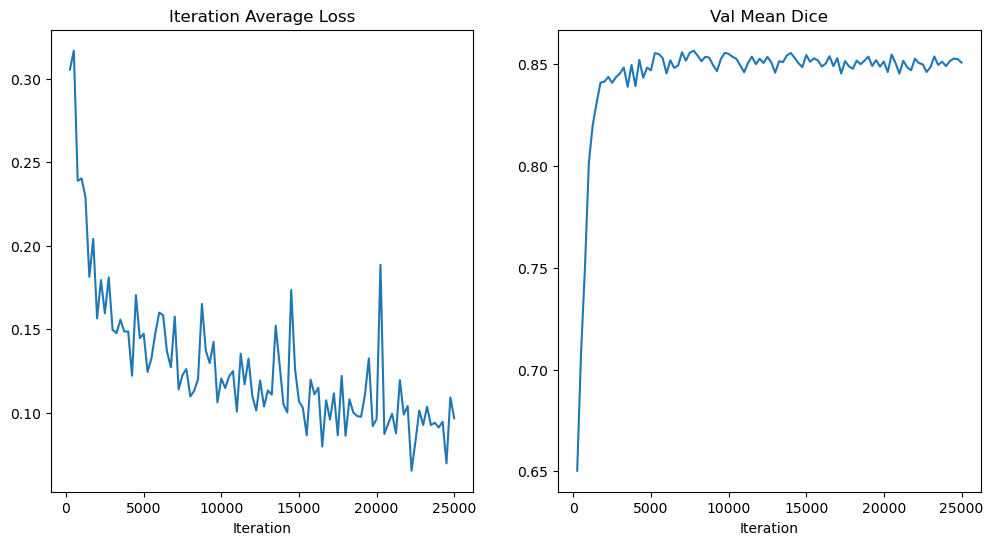

In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

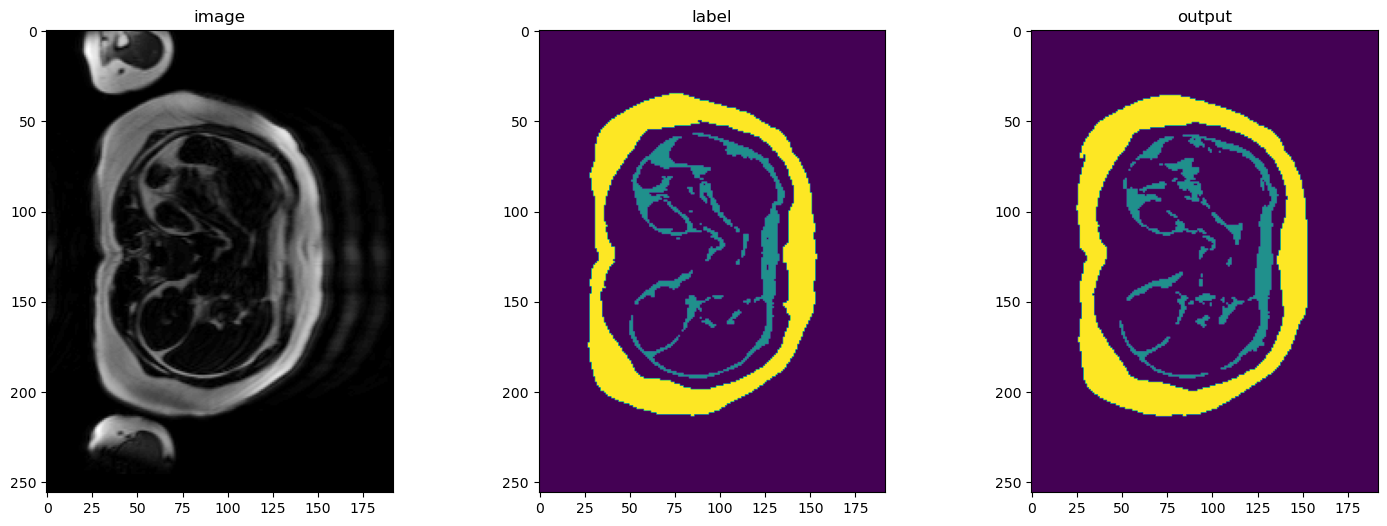

In [21]:
case_num = 2
slice_idx=35
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_idx])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx])
    plt.show()

In [22]:
out_dir = "predicted_dir/"
os.makedirs(out_dir, exist_ok=True)

In [23]:
test_transforms_encoded = Compose(    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    AsDiscreted(keys=["label"], to_onehot=num_classes),    
])

test_ds_encoded = monai.data.Dataset(data=test_files, transform=test_transforms_encoded)
test_loader_encoded = DataLoader(test_ds_encoded, batch_size=1, shuffle=False, num_workers=1)

In [24]:
# test_transforms_encoded = Compose([
#     LoadImaged(keys=["img", "label"], reader=PILReader),
#     EnsureChannelFirstd(keys=["img", "label"]),
#     ScaleIntensityd(keys=["img"], allow_missing_keys=True),
#     ResizeWithPadOrCropd(keys=["img", "label"], spatial_size=img_size),
#     Flipd(keys=["img", "label"], spatial_axis=0),
#     Rotate90d(keys=["img", "label"], k=3),    
#     EnsureTyped(keys=["img", "label"]),

# #     Resized(keys=["img", "label"], spatial_size=img_size, mode="bilinear"), 
# #     SpatialPadd(keys=["img", "label"], spatial_size=1024),
#     AsDiscreted(keys=["label"], to_onehot=3),    
# ])

# test_ds_encoded = monai.data.Dataset(data=test_files, transform=test_transforms_encoded)
# test_loader_encoded = DataLoader(test_ds_encoded, batch_size=1, shuffle=False, num_workers=1)

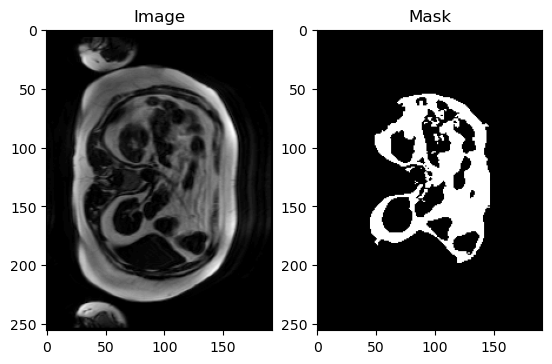

In [25]:
slice_idx= 35
batch = next(iter(test_loader_encoded))

# Get the first image and mask from the batch
img = batch["image"][0][0]
mask = batch["label"][0, 1]

# Plot the image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.cpu().numpy()[:, :, slice_idx], cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(mask.cpu().numpy()[:, :, slice_idx], cmap="gray")
ax[1].set_title("Mask")
plt.show()

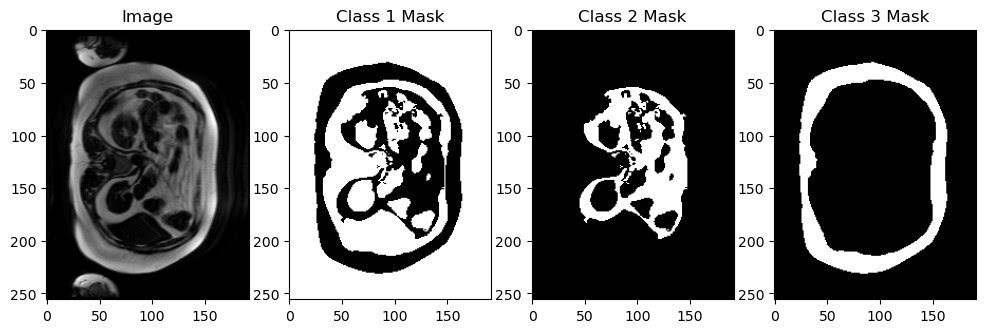

In [26]:
import matplotlib.pyplot as plt

# get the first batch of data
batch = next(iter(test_loader_encoded))

# plot the first image and the corresponding masks
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
axs[0].imshow(batch["image"][0, 0].cpu().numpy()[:, :, slice_idx], cmap="gray")
axs[0].set_title("Image")
for i in range(3):
    mask = batch["label"][0, i].cpu().numpy()[:, :, slice_idx]
    axs[i+1].imshow(mask, cmap="gray")
    axs[i+1].set_title(f"Class {i+1} Mask")
plt.show()

# Note: batch["img"][0, 0], The second [0] is indexing the first channel in the image.
# Note: batch["img"][0][0] is equal to batch["img"][0, 0]

In [27]:
iou_metric= MeanIoU(include_background=True, reduction="mean", get_not_nans=False)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(os.path.join(model_path, "best_metric_model.pth")))
model = model.to(device) 

post_trans = Compose([Activations(softmax=True)])
model.eval()
with torch.no_grad():
    dice_scores_classes = []
    iou_scores_classes = []
    for test_data in test_loader_encoded:
        test_images, test_labels = test_data["image"].to(device), test_data["label"].to(device)
        test_image_name = os.path.basename(test_data["image_meta_dict"]["filename_or_obj"][0])
#         print(test_image_name)
        roi_size = roi_size
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        test_labels = decollate_batch(test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)
        dice_score= dice_metric(y_pred=test_outputs, y=test_labels)
        iou_score = iou_metric(y_pred=test_outputs, y=test_labels)
        dice_avg = dice_score.mean().item()
        iou_avg = iou_score.mean().item()
        dice_classes= dice_score.tolist()
        iou_classes= iou_score.tolist()
        dice_report= [test_image_name, dice_classes, dice_avg]
        iou_report= [test_image_name, iou_classes, iou_avg]
        dice_scores_classes.append(dice_report)
        iou_scores_classes.append(iou_report)

dice_scores_classes = np.array(dice_scores_classes, dtype=object)
mean_avg_dice_score = dice_scores_classes[:, 2].mean()

iou_scores_classes = np.array(iou_scores_classes, dtype=object)
mean_avg_iou_score = iou_scores_classes[:, 2].mean()
print(f"Dice score on test set:  {mean_avg_dice_score*100:.6}%, IoU score on test set:  {mean_avg_iou_score*100:.6}%")

/opt/conda/lib/python3.7/site-packages/monai/metrics/utils.py:219: UserWarning: y_pred should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")


Dice score on test set:  88.7636%, IoU score on test set:  81.5225%


In [29]:
iou_scores_classes

array([[list([[0.9643394947052002, 0.7548403739929199, 0.9060396552085876]]),
        0.8750731945037842],
       [list([[0.983063280582428, 0.5700721740722656, 0.8744504451751709]]),
        0.8091952800750732],
       [list([[0.9530686736106873, 0.6521510481834412, 0.8991186618804932]]),
        0.8347795009613037],
       [list([[0.9728675484657288, 0.43378162384033203, 0.8439206480979919]]),
        0.7501899600028992],
       [list([[0.9736770391464233, 0.6499230861663818, 0.9088107347488403]]),
        0.8441369533538818],
       [list([[0.9834739565849304, 0.5380122661590576, 0.7887241840362549]]),
        0.7700701951980591],
       [list([[0.9667670130729675, 0.4881898760795593, 0.8218002319335938]]),
        0.7589191198348999],
       [list([[0.9690202474594116, 0.7484039664268494, 0.9456376433372498]]),
        0.8876873254776001],
       [list([[0.9695680141448975, 0.5800033211708069, 0.8713588714599609]]),
        0.8069767355918884]], dtype=object)

In [30]:
dice_scores_classes

array([[list([[0.981846034526825, 0.8602952361106873, 0.9507039189338684]]),
        0.9309484362602234],
       [list([[0.991459310054779, 0.7261731624603271, 0.9330205917358398]]),
        0.8835510611534119],
       [list([[0.975970447063446, 0.7894569039344788, 0.9468799233436584]]),
        0.9041024446487427],
       [list([[0.986247181892395, 0.605087399482727, 0.9153546094894409]]),
        0.835563063621521],
       [list([[0.9866629838943481, 0.7878223061561584, 0.9522271752357483]]),
        0.9089041948318481],
       [list([[0.9916681051254272, 0.699620246887207, 0.8818846344947815]]),
        0.8577243685722351],
       [list([[0.9831027388572693, 0.6560854315757751, 0.902184784412384]]),
        0.8471243381500244],
       [list([[0.9842664003372192, 0.8560996055603027, 0.9720593690872192]]),
        0.9374751448631287],
       [list([[0.9845489263534546, 0.7341798543930054, 0.9312579035758972]]),
        0.883328914642334]], dtype=object)

In [31]:
test_org_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
    ])

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=1)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
        device="cpu",
    ),
    AsDiscreted(keys="pred", argmax=True),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_ext=".nii", output_postfix="seg", separate_folder=False, resample=False),
])

In [32]:
# SaveImaged?

In [33]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = roi_size
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "label"])(test_data)

2023-04-25 19:51:01,388 INFO image_writer.py:194 - writing: out/processed_1096_Series0025_t1_fl2d_BC_seg.nii
2023-04-25 19:51:03,781 INFO image_writer.py:194 - writing: out/processed_1043_Series0028_t1_fl2d_seg.nii
2023-04-25 19:51:06,250 INFO image_writer.py:194 - writing: out/processed_1056_Series0023_t1_fl2d_BC_seg.nii
2023-04-25 19:51:08,684 INFO image_writer.py:194 - writing: out/processed_1052_Series0023_t1_fl2d_seg.nii
2023-04-25 19:51:11,077 INFO image_writer.py:194 - writing: out/processed_1048_Series0022_t1_fl2d_seg.nii
2023-04-25 19:51:13,486 INFO image_writer.py:194 - writing: out/processed_1079_Series0024_t1_fl2d_seg.nii
2023-04-25 19:51:15,935 INFO image_writer.py:194 - writing: out/processed_1030_Series0023_t1_fl2d_seg.nii
2023-04-25 19:51:18,696 INFO image_writer.py:194 - writing: out/processed_1034_Series0023_t1_fl2d_seg.nii
2023-04-25 19:51:21,118 INFO image_writer.py:194 - writing: out/processed_1047_Series0023_t1_fl2d_BC_seg.nii


In [34]:
print(train_files)
print("=====================================================================================\n")
print(val_files)
print("=====================================================================================\n")
print(test_files)

[{'image': '/kaggle/input/washu-vat-scat-43/images_clahe/processed_1095_t1_fl2d_Series0023.nii', 'label': '/kaggle/input/washu-vat-scat-43/masks/processed_1095_t1_fl2d_Series0023.nii'}, {'image': '/kaggle/input/washu-vat-scat-43/images_clahe/processed_T1_FL2D_0004.nii', 'label': '/kaggle/input/washu-vat-scat-43/masks/processed_T1_FL2D_0004.nii'}, {'image': '/kaggle/input/washu-vat-scat-43/images_clahe/processed_1099_Series0023_t1_fl2d_BC_Low.nii', 'label': '/kaggle/input/washu-vat-scat-43/masks/processed_1099_Series0023_t1_fl2d_BC_Low.nii'}, {'image': '/kaggle/input/washu-vat-scat-43/images_clahe/processed_1019_Series21001_t1_fl2d_tra_p3_256_100.nii', 'label': '/kaggle/input/washu-vat-scat-43/masks/processed_1019_Series21001_t1_fl2d_tra_p3_256_100.nii'}, {'image': '/kaggle/input/washu-vat-scat-43/images_clahe/processed_1010_Series0004_t1_fl2d.nii', 'label': '/kaggle/input/washu-vat-scat-43/masks/processed_1010_Series0004_t1_fl2d.nii'}, {'image': '/kaggle/input/washu-vat-scat-43/images_

In [35]:
import nibabel as nib

def read_nii(volume_path):
    nii_obj= nib.load(volume_path)
    nii_data= nii_obj.get_fdata()
    return nii_data, nii_obj

def dice_coef(y_true, y_pred):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(y_true).astype(bool)
    im2 = np.asarray(y_pred).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def jaccard_index(A, B):
    '''Compute Jaccard index (IoU) between two segmentation masks.
    :param A: (numpy array) reference segmentaton mask
    :param B: (numpy array) predicted segmentaton mask
    :return: Jaccard index
    '''

    both = np.logical_and(A, B)
    either = np.logical_or(A, B)
    ji = int(np.sum(both)) / int(np.sum(either))

    return ji

prediction_dir="/kaggle/working/out/"
pred_files= glob.glob(prediction_dir+"*.nii")
pred_files= [fname.replace('_seg', '') for fname in pred_files]
test_pred_files= [os.path.basename(fname) for fname in pred_files]
test_truth_files = sorted(test_masks)


prediction_results= []
for test_truth, test_pred in zip(sorted(test_truth_files), sorted(test_pred_files)):
#     print(test_truth, test_pred)
    y_true_path= os.path.join(data_dir, 'masks/',test_truth)
#     print("****", test_fname)  
    y_true = nib.load(y_true_path).get_fdata()
    
    y_pred_path=os.path.join(prediction_dir,test_pred.replace(".nii", "_seg.nii"))
#     print("****", y_pred_path)
    y_pred= nib.load(y_pred_path).get_fdata()
    print(y_true.shape, y_pred.shape)
    
    jaccard_score = jaccard_index(y_true, y_pred)
    dice_score = dice_coef(y_true, y_pred)
    print("image: {} -- jaccard index: {} -- dice score: {}".format(test_truth, jaccard_score, dice_score))
    prediction_results.append([test_truth, jaccard_score, dice_score])
    print("======"* 15)
    
    
df= pd.DataFrame(prediction_results, columns=['file', 'jaccard_score', 'dice_score'])
ds_col= df['dice_score'].values
js_col= df['jaccard_score'].values
print("============" * 12)
print("Dice score Mean: {}, +- {} std, Median: {}".format(np.mean(ds_col), np.std(ds_col), np.median(ds_col)))
print("Jaccard score Mean: {}, +- {} std, Median: {}".format(np.mean(js_col), np.std(js_col), np.median(js_col)))
print("============" * 12)
save_path = "dice_jaccard_results.csv"
df.to_csv(save_path, sep=',')    

(256, 192, 64) (256, 192, 64)
image: /kaggle/input/washu-vat-scat-43/masks/processed_1030_Series0023_t1_fl2d.nii -- jaccard index: 0.6981974631427657 -- dice score: 0.8222806573396335
(256, 192, 64) (256, 192, 64)
image: /kaggle/input/washu-vat-scat-43/masks/processed_1034_Series0023_t1_fl2d.nii -- jaccard index: 0.8945721835375595 -- dice score: 0.9443527053872475
(256, 192, 64) (256, 192, 64)
image: /kaggle/input/washu-vat-scat-43/masks/processed_1043_Series0028_t1_fl2d.nii -- jaccard index: 0.7927129216178714 -- dice score: 0.8843724079396617
(256, 192, 64) (256, 192, 64)
image: /kaggle/input/washu-vat-scat-43/masks/processed_1047_Series0023_t1_fl2d_BC.nii -- jaccard index: 0.7724583366557691 -- dice score: 0.8716236886145652
(256, 192, 64) (256, 192, 64)
image: /kaggle/input/washu-vat-scat-43/masks/processed_1048_Series0022_t1_fl2d.nii -- jaccard index: 0.8445822319398666 -- dice score: 0.9157436489580151
(256, 192, 64) (256, 192, 64)
image: /kaggle/input/washu-vat-scat-43/masks/pr